In [2]:
from koala.pointsets import uniform
from koala import graph_utils as gu
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
import math
from koala.flux_finder import fluxes_from_ujk, ujk_from_fluxes

from scipy import linalg as la

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1]
30


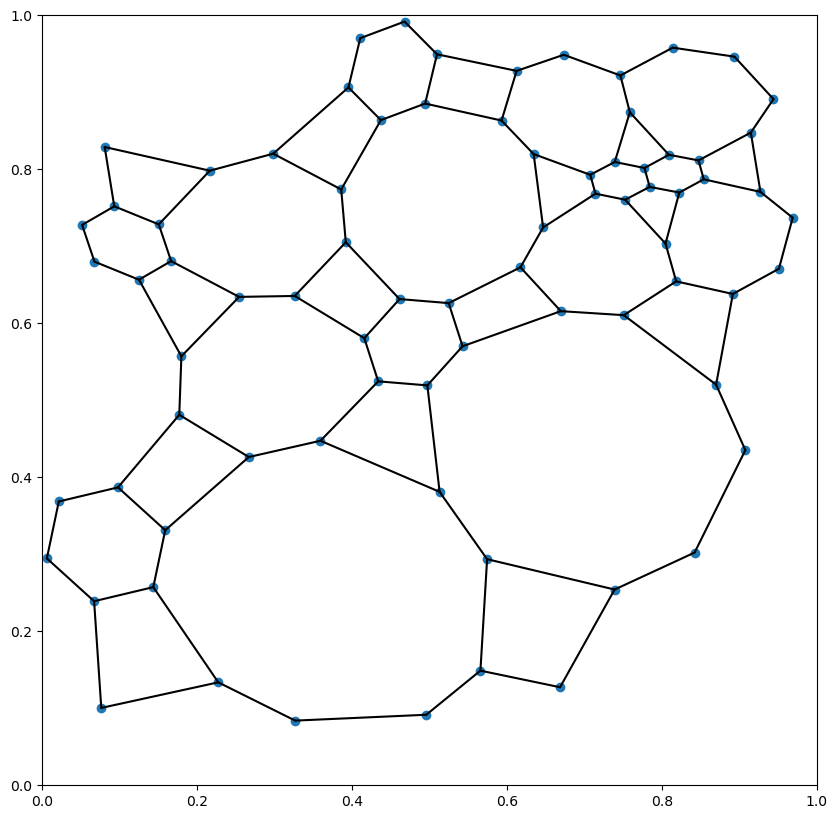

In [3]:
n_vert = 1

cut_boundaries = True

lattice = generate_lattice(uniform(20))
dimerisation = gu.dimerise(lattice)
lattice = gu.dimer_collapse(lattice, dimerisation)
lattice = gu.vertices_to_polygon(lattice)
if cut_boundaries:
    lattice = gu.cut_boundaries(lattice)
    lattice = gu.remove_trailing_edges(lattice)
fig, ax = plt.subplots(figsize=(10, 10))
pl.plot_edges(lattice)
plt.scatter(lattice.vertices.positions[:, 0], lattice.vertices.positions[:, 1])

coloring = color_lattice(lattice)


fluxes = np.array([-1] * lattice.n_plaquettes)
ujk = ujk_from_fluxes(lattice, fluxes)
fluxes = fluxes_from_ujk(lattice, ujk)
print(fluxes)


print(lattice.n_plaquettes)

In [4]:
from koala import hamiltonian


def kastelyn_matrix(lattice, ujk):
    matrix = np.zeros([lattice.n_vertices, lattice.n_vertices])
    edges = lattice.edges.indices
    matrix[edges[:, 0], edges[:, 1]] = ujk
    matrix[edges[:, 1], edges[:, 0]] = -ujk

    return matrix


mat_1 = kastelyn_matrix(lattice, ujk)
n_dimers = np.sqrt(np.abs(la.det(mat_1))).astype(int)
n_dimers

np.int64(0)

In [5]:
dimers = gu.dimerise(lattice, n_dimers + 100)
print(dimers.shape[0])

ValueError: No dimerisation exists for this lattice.

In [ ]:


plaquette_scores = np.zeros([dimers.shape[0], lattice.n_plaquettes])
for i, dimerisation in enumerate(dimers):
    plaquette_scores[i] = np.array(
        [np.sum(1 - 2 * dimerisation[p.edges]) for p in lattice.plaquettes]
    )
plaquette_scores = np.array(plaquette_scores) / 2

In [ ]:
external_scores = lattice.n_plaquettes - 1 - np.sum(plaquette_scores, axis=1)
external_scores = external_scores.astype(int)
if not cut_boundaries:
    external_scores *= 0

(array([1, 2]), array([61648,    16]))


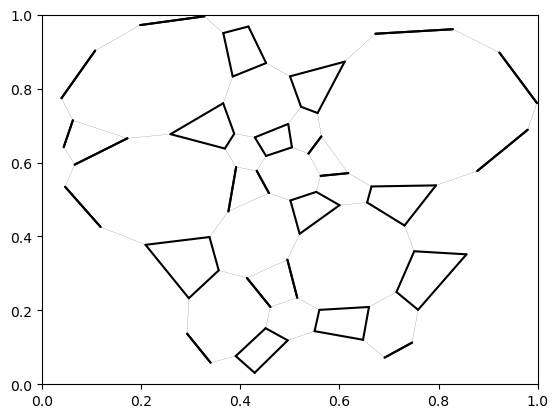

In [ ]:
scores, counts = np.unique(plaquette_scores, axis=0, return_counts=True)

print(np.unique(counts, return_counts=True))

repeated_scores = np.argwhere(counts > 1)
for repeat_score in repeated_scores:
    repeated_dimer_indices = np.argwhere(
        np.all(plaquette_scores == scores[repeat_score], axis=1)
    ).flatten()

    same_dimerications = dimers[repeated_dimer_indices]

    pl.plot_edges(lattice, linewidth=0.1)
    pl.plot_edges(lattice, subset=np.where(same_dimerications[0] == 1))
    pl.plot_edges(lattice, subset=np.where(same_dimerications[1] == 1))
    plt.show()
    break

In [ ]:
how_flippable = np.sum(plaquette_scores == 0, axis=1) + (external_scores == 0)
# how_flippable = np.sum(plaquette_scores == 0, axis=1)

most_flipped = np.max(how_flippable)
most_flippable_indices = np.where(how_flippable == most_flipped)[0]
most_flippable_dimerisations = dimers[most_flippable_indices]
num_most = most_flippable_indices.shape[0]
print(f"{num_most} dimerisations have {most_flipped}/{lattice.n_plaquettes} flippable")

least_flipped = np.min(how_flippable)
least_flippable_indices = np.where(how_flippable == least_flipped)[0]
least_flippable_dimerisations = dimers[least_flippable_indices]
num_least = least_flippable_indices.shape[0]
print(
    f"{num_least} dimerisations have {least_flipped}/{lattice.n_plaquettes} flippable"
)

1 dimerisations have 21/27 flippable
3 dimerisations have 2/27 flippable


3


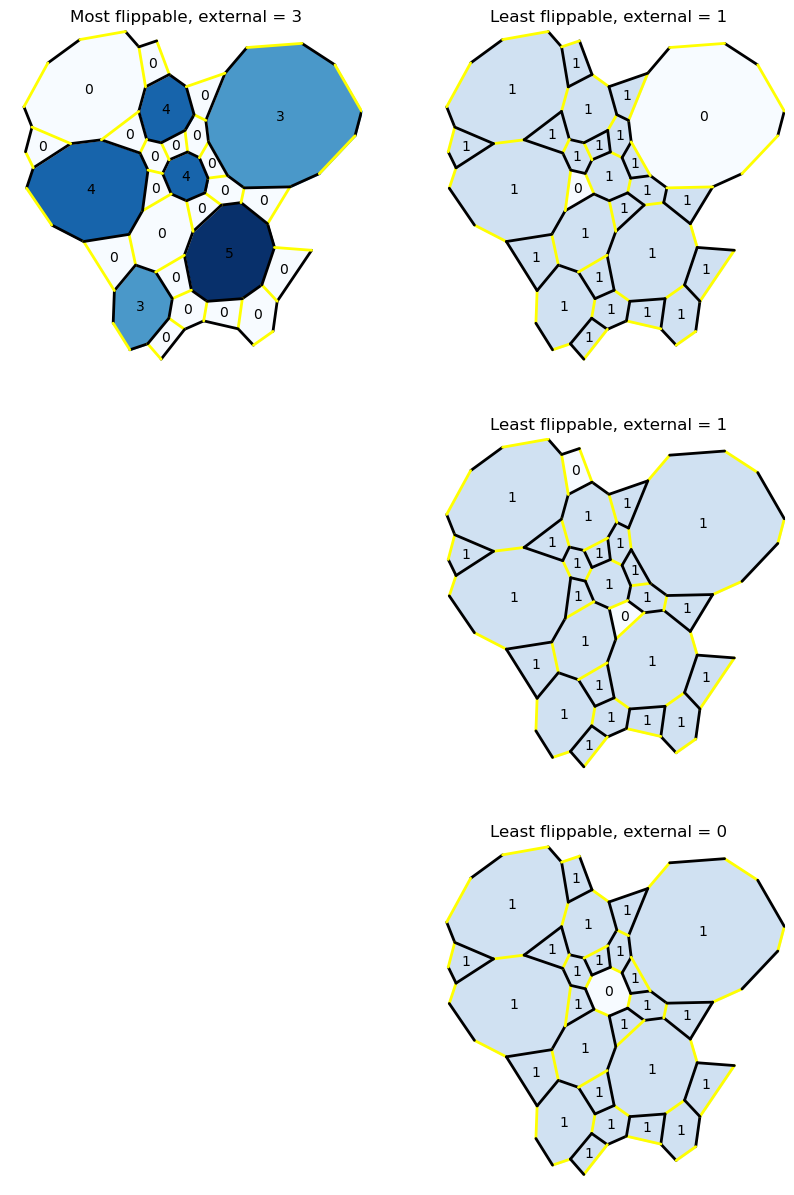

In [ ]:
cmap = mpl.colormaps["Blues"]
colors = cmap(np.linspace(0, 1, np.max([plaquette_scores.astype("int")]) + 1))

# Take colors at regular intervals spanning the colormap.
# colors = cmap(np.linspace(0, 1, max(least_flippable_dimerisations.max(), least_flippable_dimerisations.max()) + 1))

x = np.max([num_least, num_most]).astype(int)
print(x)
fig, ax = plt.subplots(x, 2, figsize=(10, 5 * x))
# ax[0].set_title("Most flippable")
# ax[1].set_title("Least flippable")

for n, index in enumerate(most_flippable_indices):
    dim_to_plot = dimers[index]
    score_to_plot = plaquette_scores[index]
    external = external_scores[index]

    pl.plot_plaquettes(lattice, score_to_plot, colors, ax=ax[n, 0])
    pl.plot_edges(lattice, dim_to_plot, ["k", "yellow"], ax=ax[n, 0], linewidth=2)

    for i in range(lattice.n_plaquettes):
        x, y = lattice.plaquettes[i].center % 1
        ax[n, 0].annotate(
            score_to_plot[i].astype("int"), (x, y), ha="center", va="center"
        )
        ax[n, 0].set_title(f"Most flippable, external = {external}")


for n, index in enumerate(least_flippable_indices):
    dim_to_plot = dimers[index]
    score_to_plot = plaquette_scores[index]
    external = external_scores[index]

    pl.plot_plaquettes(lattice, score_to_plot, colors, ax=ax[n, 1])
    pl.plot_edges(lattice, dim_to_plot, ["k", "yellow"], ax=ax[n, 1], linewidth=2)

    for i in range(lattice.n_plaquettes):
        x, y = lattice.plaquettes[i].center % 1
        ax[n, 1].annotate(
            score_to_plot[i].astype("int"), (x, y), ha="center", va="center"
        )
        ax[n, 1].set_title(f"Least flippable, external = {external}")

for a in ax.flatten():
    a.axis("off")

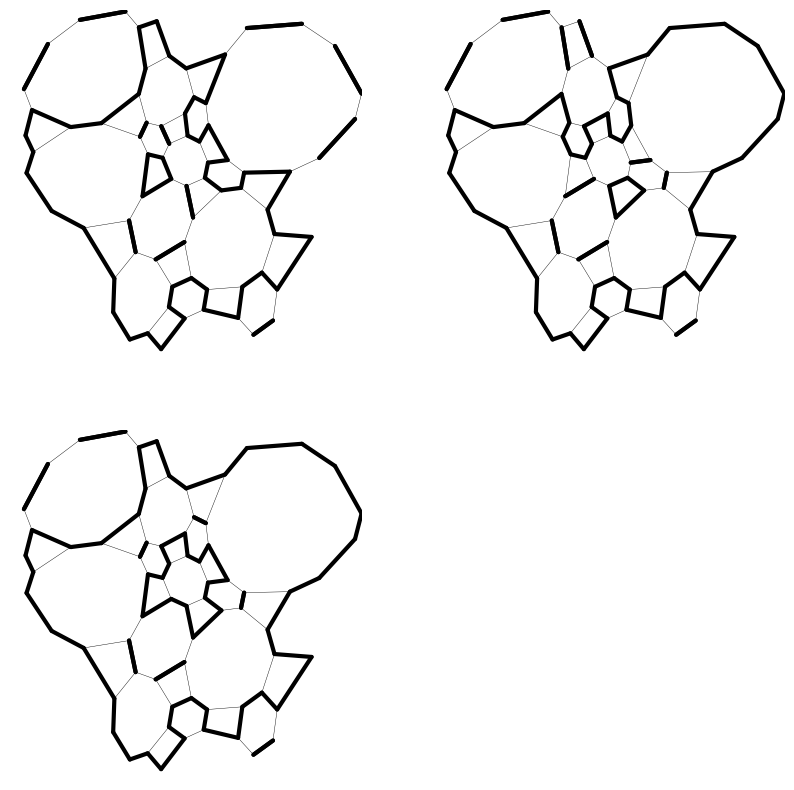

In [ ]:
n_plots = most_flippable_dimerisations.shape[0] * least_flippable_dimerisations.shape[0]
n_rows = math.ceil(np.sqrt(n_plots))

all_pairings_most, all_pairings_least = np.meshgrid(
    np.arange(most_flippable_dimerisations.shape[0]),
    np.arange(least_flippable_dimerisations.shape[0]),
)
all_pairings_most = all_pairings_most.flatten()
all_pairings_least = all_pairings_least.flatten()

fig, axes = plt.subplots(n_rows, n_rows, figsize=(10, 10))
for n, ax in enumerate(axes.flatten()):
    most = most_flippable_dimerisations[all_pairings_most[n]]
    least = least_flippable_dimerisations[all_pairings_least[n]]

    pl.plot_edges(lattice, subset=np.where(most == 1), ax=ax, linewidth=3)
    pl.plot_edges(lattice, subset=np.where(least == 1), ax=ax, linewidth=3)
    pl.plot_edges(lattice, ax=ax, linewidth=0.3)

    if n == all_pairings_most.shape[0] - 1:
        break

for a in axes.flatten():
    a.axis("off")